In [1]:
# import libraries
import pandas as pd
import random
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt

# import nltk
# nltk.download('stopwords')

In [2]:
def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocesses the data by removing punctuation, numbers, stopwords, and short words.
    """
    # lowercase
    data["text"] = data["text"].apply(lambda x: x.lower())
    # remove punctuation
    data["text"] = data["text"].apply(lambda x: re.sub(r"[^\w\s]", "", x))
    # remove numbers
    data["text"] = data["text"].apply(lambda x: re.sub(r"\d+", "", x))
    # remove stopwords
    stop = stopwords.words("english")
    data["text"] = data["text"].apply(
        lambda x: " ".join(x for x in x.split() if x not in stop)
    )
    # stemming
    st = PorterStemmer()
    data["text"] = data["text"].apply(
        lambda x: " ".join([st.stem(word) for word in x.split()])
    )
    # remove short words
    data["text"] = data["text"].apply(
        lambda x: " ".join(x for x in x.split() if len(x) > 3)
    )
    return data

In [3]:
def create_label_words(data: pd.DataFrame, label: str) -> pd.Series:
    """
    Create a list of words from a given label
    """
    label_words = []
    for text in data[data["label"] == label]["text"]:
        for word in text.split():
            label_words.append(word)
    label_words = pd.Series(label_words)
    return label_words

In [4]:
def create_vocab(data: list) -> list:
    """
    Create a vocabulary from a given list of words
    """
    vocab = set()
    for text in data:
        for word in text.split():
            vocab.add(word)
    vocab = list(vocab)
    return vocab

In [5]:
def prepare_dataset(dataset_path: str) -> tuple:
    """
    This function takes the path of the dataset and returns the vocabulary and the word counts for each label.
    """
    DATA_PATH = dataset_path
    data = pd.read_csv(DATA_PATH)
    data = data.rename(columns={"text": "text", "category": "label"})
    data = preprocess_data(data)
    
    vocab =  create_vocab(data["text"])
    labels = data["label"].unique()
    
    first_label = labels[0]
    second_label = labels[1]

    first_label_words = create_label_words(data, first_label)
    second_label_words = create_label_words(data, second_label)

    first_label_words = first_label_words.value_counts()
    second_label_words = second_label_words.value_counts()

    return vocab, first_label_words, second_label_words

In [6]:
def create_individual(word_count: int, vocab: list) -> list:
    """
    Creates an individual with a given word count and vocabulary.
    """
    individual = [[], []]
    for i in range(word_count // 2):
        individual[0].append(random.choice(vocab))
        individual[1].append(random.choice(vocab))
    return individual

In [7]:
def create_population(population_size: int, word_count: int, vocab: list) -> list:
    """
    Creates a population with a given size, word count, and vocabulary.
    """
    population = []
    for i in range(population_size):
        individual = create_individual(word_count, vocab)
        if individual not in population:
            population.append(individual)
    return population

In [8]:
def find_fitness(
    individual: list, first_label_words: pd.Series, second_label_words: pd.Series
) -> int:
    """
    Finds the fitness of an individual.
    """
    fitness = 0
    for word in individual[0]:
        if word in first_label_words:
            fitness += first_label_words[word]
        if word in second_label_words:
            fitness -= second_label_words[word]
    for word in individual[1]:
        if word in second_label_words:
            fitness += second_label_words[word]
        if word in first_label_words:
            fitness -= first_label_words[word]
    return fitness

In [9]:
def find_population_fitness(
    population: list, first_label_words: pd.Series, second_label_words: pd.Series
) -> list:
    """
    Finds the fitness of each individual in a population.
    """
    population_fitness = []
    for individual in population:
        population_fitness.append(
            find_fitness(individual, first_label_words, second_label_words)
        )
    return population_fitness

In [10]:
def find_best(population: list, population_fitness: list) -> list:
    """
    Finds the best individual in a population.
    """
    best_index = population_fitness.index(max(population_fitness))
    return population[best_index]

In [11]:
def find_elites(population: list, population_fitness: list, elite_size: int) -> list:
    """
    Finds the elite individuals in a population.
    """
    elites = []
    for i in range(elite_size):
        best_index = population_fitness.index(max(population_fitness))
        elites.append(population[best_index])
        population_fitness[best_index]
    return elites

In [12]:
def crossover(parent1: list, parent2: list) -> list:
    """
    Creates a child from two parents.
    """
    child = [[], []]
    for i in range(len(parent1[0])):
        if random.random() > 0.5:
            child[0].append(parent1[0][i])
            child[1].append(parent2[1][i])
        else:
            child[0].append(parent2[0][i])
            child[1].append(parent1[1][i])
    return child

In [13]:
def mutate(individual: list, mutation_rate: float, vocab: list) -> list:
    """
    Mutates an individual.
    """
    for i in range(len(individual[0])):
        if random.random() < mutation_rate:
            individual[0][i] = random.choice(vocab)
        if random.random() < mutation_rate:
            individual[1][i] = random.choice(vocab)
    return individual

In [14]:
def check_if_unique(individual: list) -> bool:
    """
    Checks if an individual is unique. Purpose is to avoid duplicates in a population.
    """
    # Check if individual[0] and individual[1] is unique
    if len(set(individual[0])) != len(individual[0]):
        return False
    if len(set(individual[1])) != len(individual[1]):
        return False
    return True


def evolve(
    population: list,
    population_fitness: list,
    elite_size: int,
    mutation_rate: float,
    vocab: list,
) -> list:
    """
    Evolves a population.
    """
    elites = find_elites(population, population_fitness, elite_size)
    next_generation = elites
    while len(next_generation) < len(population):
        parent1 = random.choice(next_generation)
        parent2 = random.choice(next_generation)
        child = crossover(parent1, parent2)
        child = mutate(child, mutation_rate, vocab)
        if child not in next_generation and check_if_unique(child):
            next_generation.append(child)
    return next_generation

In [15]:
def genetic_algorithm(
    population_size: int,
    elite_size: int,
    mutation_rate: float,
    generation_count: int,
    word_count: int,
    vocab: list,
    first_label_words: pd.Series,
    second_label_words: pd.Series,
) -> tuple:
    """
    Runs the genetic algorithm.
    """
    population = create_population(population_size, word_count, vocab)
    plot_data = {}
    for i in range(generation_count):
        population_fitness = find_population_fitness(
            population, first_label_words, second_label_words
        )
        population = evolve(
            population, population_fitness, elite_size, mutation_rate, vocab
        )
        plot_data[i] = {
            "max": max(population_fitness),
            "avg": sum(population_fitness) / len(population_fitness),
        }
    population_fitness = find_population_fitness(
        population, first_label_words, second_label_words
    )
    best = find_best(population, population_fitness)
    return best, population_fitness, plot_data

In [16]:
def plot_generations_fitness_graph(plot_data: dict, title: str, description: str = None):
    """
    Plots the fitness of max and avg fitness of each generation.
    """
    plt.figure(figsize=(5, 5))
    plt.plot(
        list(plot_data.keys()),
        [plot_data[key]["max"] for key in plot_data.keys()],
        label="Max",
    )
    plt.plot(
        list(plot_data.keys()),
        [plot_data[key]["avg"] for key in plot_data.keys()],
        label="Avg",
    )
    plt.legend()
    plt.title(title)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    if description:
        plt.text(25, 50, description)
    return plt

In [17]:
DATA_PATH_LIST = [
    "science_politics.csv",
    "sports_business.csv",
    "sports_sci-tech.csv",
    "travel_education.csv",
    "world_sports.csv",
]

PARAMETER_LIST = [
    # word_count changes
    [
        {
            "population_size": 100,
            "word_count": 20,
            "mutation_rate": 0.01,
        },
        {
            "population_size": 100,
            "word_count": 30,
            "mutation_rate": 0.01,
        },
        {
            "population_size": 100,
            "word_count": 40,
            "mutation_rate": 0.01,
        },
    ],
    # population_size changes
    [
        {
            "population_size": 100,
            "word_count": 30,
            "mutation_rate": 0.01,
        },
        {
            "population_size": 150,
            "word_count": 30,
            "mutation_rate": 0.01,
        },
        {
            "population_size": 200,
            "word_count": 30,
            "mutation_rate": 0.01,
        },
    ],
    # mutation_rate changes
    [
        {
            "population_size": 100,
            "word_count": 30,
            "mutation_rate": 0.01,
        },
        {
            "population_size": 100,
            "word_count": 30,
            "mutation_rate": 0.05,
        },
        {
            "population_size": 100,
            "word_count": 30,
            "mutation_rate": 0.10,
        },
    ],
]


In [18]:
for data_path in DATA_PATH_LIST:
    vocab, first_label_words, second_label_words = prepare_dataset(
        f"dataset/{data_path}"
    )
    best, population_fitness, plot_data = genetic_algorithm(
        population_size=100,
        elite_size=20,
        mutation_rate=0.05,
        generation_count=50,
        word_count=20,
        vocab=vocab,
        first_label_words=first_label_words,
        second_label_words=second_label_words,
    )
    print(f"--- {data_path} Results ---")
    print("Best individual:", best)
    print("Best fitness:", max(population_fitness))

--- science_politics.csv Results ---
Best individual: [['orbit', 'human', 'tuesday', 'binari', 'evid', 'intern', 'littl', 'eclips', 'probe', 'máaz'], ['feder', 'justic', 'biden', 'leader', 'presid', 'republican', 'trump', 'democrat', 'call', 'hous']]
Best fitness: 121
--- sports_business.csv Results ---
Best individual: [['sport', 'team', 'olymp', 'valieva', 'beij', 'black', 'hamilton', 'compet', 'winter', 'bull'], ['inflat', 'trade', 'price', 'russian', 'feder', 'leader', 'ukrain', 'rise', 'year', 'home']]
Best fitness: 162
--- sports_sci-tech.csv Results ---
Best individual: [['team', 'beat', 'puerto', 'sunday', 'open', 'lead', 'doubl', 'wrap', 'inning', 'athen'], ['scientist', 'scienc', 'work', 'nest', 'instrument', 'surrend', 'studi', 'spacecom', 'logger', 'planet']]
Best fitness: 267
--- travel_education.csv Results ---
Best individual: [['mumbai', 'atacama', 'tallinn', 'apolog', 'tour', 'citi', 'room', 'sign', 'fern', 'currenc'], ['page', 'structur', 'aspect', 'research', 'softwa

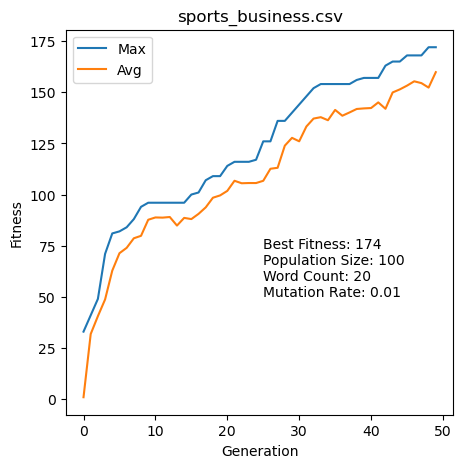

--- sports_business.csv Results ---
Params: {'population_size': 100, 'word_count': 20, 'mutation_rate': 0.01}
Best individual: [['winter', 'olymp', 'sunday', 'compet', 'skate', 'golf', 'figur', 'beij', 'leagu', 'final'], ['last', 'rate', 'ukrain', 'economi', 'rise', 'monday', 'year', 'across', 'china', 'plan']]
Best fitness: 174


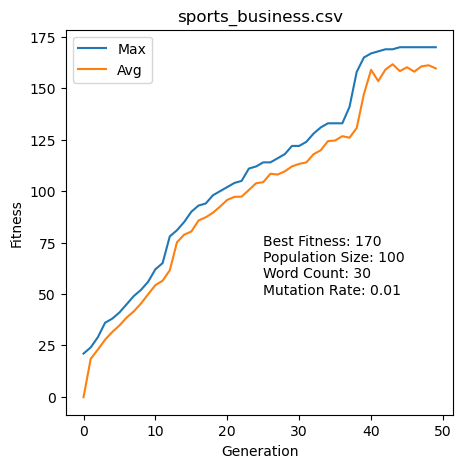

--- sports_business.csv Results ---
Params: {'population_size': 100, 'word_count': 30, 'mutation_rate': 0.01}
Best individual: [['histori', 'pari', 'england', 'winter', 'saturday', 'sunday', 'unlik', 'kamila', 'tenni', 'medal', 'golf', 'madison', 'competit', 'intend', 'bitter'], ['nuclear', 'member', 'privileg', 'attack', 'moscow', 'pandem', 'govern', 'increas', 'supplier', 'rise', 'plan', 'ukrain', 'russia', 'market', 'price']]
Best fitness: 170


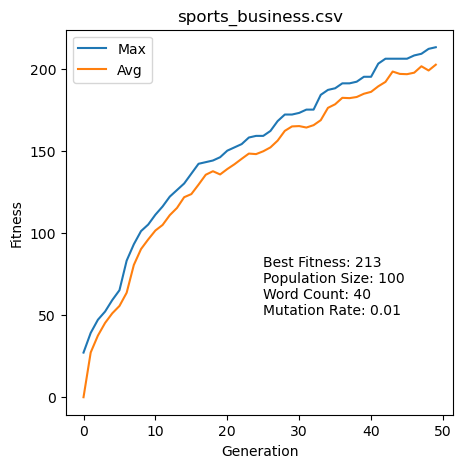

--- sports_business.csv Results ---
Params: {'population_size': 100, 'word_count': 40, 'mutation_rate': 0.01}
Best individual: [['chanc', 'hope', 'first', 'saintgermain', 'pair', 'napoli', 'condit', 'footbal', 'lewi', 'golfer', 'hometown', 'player', 'bobsl', 'leagu', 'saturday', 'finish', 'yarmolenko', 'beij', 'olymp', 'team'], ['monday', 'price', 'home', 'week', 'billion', 'work', 'inflat', 'financi', 'crisi', 'covid', 'high', 'econom', 'seen', 'million', 'year', 'govern', 'state', 'gallon', 'space', 'america']]
Best fitness: 213


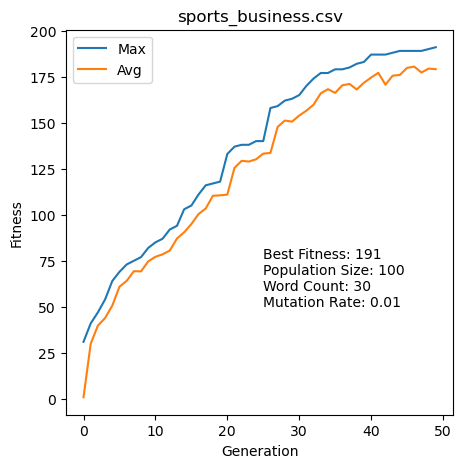

--- sports_business.csv Results ---
Params: {'population_size': 100, 'word_count': 30, 'mutation_rate': 0.01}
Best individual: [['kamila', 'player', 'compet', 'sport', 'winter', 'bowl', 'valieva', 'night', 'play', 'athlet', 'olymp', 'competit', 'beij', 'club', 'medal'], ['across', 'inflat', 'year', 'recoveri', 'pandem', 'invest', 'jump', 'india', 'cryptocurr', 'would', 'keep', 'ukrain', 'invas', 'scrutini', 'supplier']]
Best fitness: 191


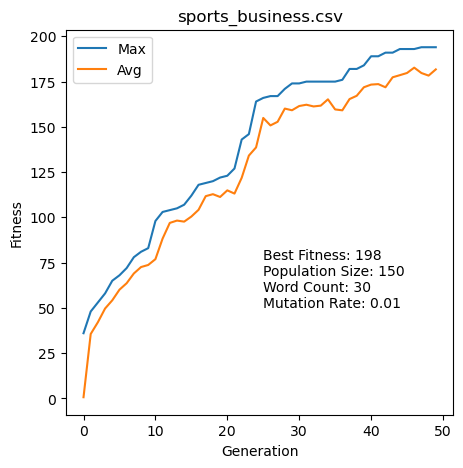

--- sports_business.csv Results ---
Params: {'population_size': 150, 'word_count': 30, 'mutation_rate': 0.01}
Best individual: [['thursday', 'sport', 'medal', 'skate', 'saintgermain', 'team', 'player', 'leagu', 'athlet', 'sunday', 'golfer', 'goal', 'winter', 'olymp', 'brittani'], ['space', 'ukrain', 'work', 'student', 'last', 'creat', 'difficult', 'report', 'egregi', 'million', 'rent', 'econom', 'increas', 'russia', 'currenc']]
Best fitness: 198


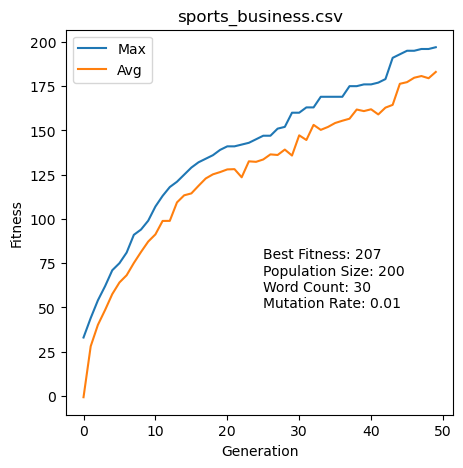

--- sports_business.csv Results ---
Params: {'population_size': 200, 'word_count': 30, 'mutation_rate': 0.01}
Best individual: [['remain', 'formula', 'sport', 'gold', 'skate', 'medal', 'leagu', 'winter', 'golf', 'final', 'olymp', 'beij', 'committe', 'club', 'match'], ['rate', 'launch', 'take', 'china', 'keep', 'monday', 'block', 'inflat', 'compani', 'work', 'crisi', 'invas', 'pandem', 'economi', 'week']]
Best fitness: 207


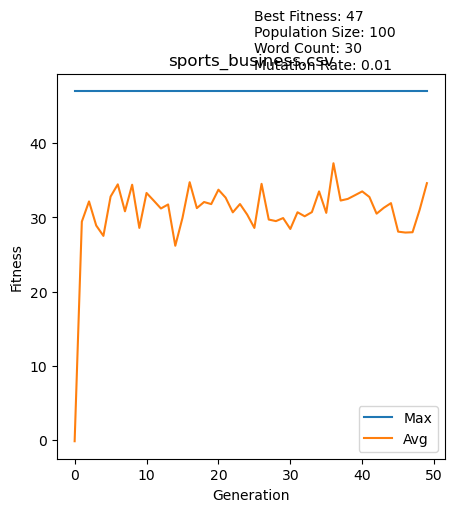

--- sports_business.csv Results ---
Params: {'population_size': 100, 'word_count': 30, 'mutation_rate': 0.01}
Best individual: [['tenni', 'atalanta', 'extens', 'higher', 'wealth', 'unbeliev', 'spellbind', 'club', 'attack', 'seen', 'investig', 'togeth', 'unfold', 'order', 'promis'], ['client', 'suddenli', 'reject', 'much', 'ukrain', 'level', 'left', 'union', 'annual', 'ukrain', 'store', 'rebuild', 'televis', 'privat', 'pain']]
Best fitness: 47


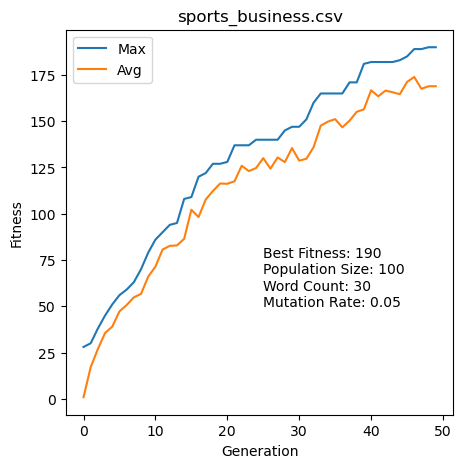

--- sports_business.csv Results ---
Params: {'population_size': 100, 'word_count': 30, 'mutation_rate': 0.05}
Best individual: [['tour', 'kamila', 'abramovich', 'olymp', 'rich', 'champion', 'wednesday', 'medal', 'blood', 'wasnt', 'beij', 'first', 'intend', 'stone', 'figur'], ['need', 'russia', 'year', 'rate', 'spotifi', 'ukrain', 'pandem', 'academi', 'climat', 'global', 'creat', 'price', 'food', 'block', 'work']]
Best fitness: 190


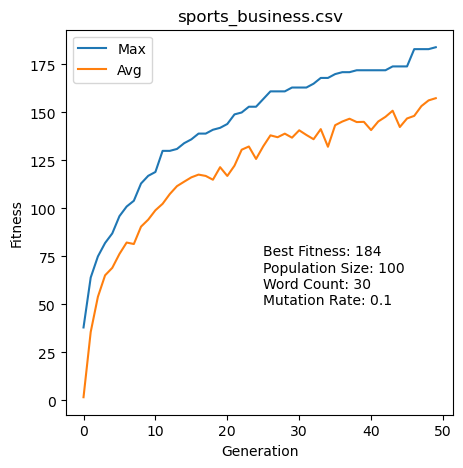

--- sports_business.csv Results ---
Params: {'population_size': 100, 'word_count': 30, 'mutation_rate': 0.1}
Best individual: [['skate', 'player', 'star', 'türkgücü', 'winter', 'took', 'beij', 'saturday', 'munich', 'committe', 'suddenli', 'tampa', 'without', 'play', 'chelsea'], ['home', 'difficult', 'chip', 'week', 'ukrain', 'across', 'russia', 'increas', 'rate', 'disast', 'monday', 'program', 'invas', 'export', 'price']]
Best fitness: 184


In [19]:
data_path = DATA_PATH_LIST[1]
for parameters in PARAMETER_LIST:
    for parameter in parameters:
        vocab, first_label_words, second_label_words = prepare_dataset(
            f"dataset/{data_path}"
        )
        best, population_fitness, plot_data = genetic_algorithm(
            population_size=parameter["population_size"],
            elite_size=20,
            mutation_rate=parameter["mutation_rate"],
            generation_count=50,
            word_count=parameter["word_count"],
            vocab=vocab,
            first_label_words=first_label_words,
            second_label_words=second_label_words,
        )
        plot_image = plot_generations_fitness_graph(
            plot_data,
            data_path,
            f"Best Fitness: {max(population_fitness)}\nPopulation Size: {parameter['population_size']}\nWord Count: {parameter['word_count']}\nMutation Rate: {parameter['mutation_rate']}",
        )
        plot_image.show()
        print(f"--- {data_path} Results ---")
        print("Params:", parameter)
        print("Best individual:", best)
        print("Best fitness:", max(population_fitness))

In [ ]:
# GUI

from tkinter import ttk
import tkinter as tk
import io

# Create a Tkinter window
root = tk.Tk()
root.title("Genetic Algorithm")

# Create a dropdown select box for data paths
data_label = ttk.Label(root, text="Select data set")
data_label.grid(column=0, row=0)
data_path_var = tk.StringVar()
data_path_dropdown = ttk.Combobox(
    root, textvariable=data_path_var, values=DATA_PATH_LIST
)
data_path_dropdown.grid(column=1, row=0)
data_path_dropdown.current(0)

# Create input boxes for genetic algorithm parameters
population_size_label = ttk.Label(root, text="Population Size:")
population_size_label.grid(column=0, row=1)
population_size_entry = ttk.Entry(root)
population_size_entry.grid(column=1, row=1)

elite_size_label = ttk.Label(root, text="Elite Size:")
elite_size_label.grid(column=0, row=2)
elite_size_entry = ttk.Entry(root)
elite_size_entry.grid(column=1, row=2)

mutation_rate_label = ttk.Label(root, text="Mutation Rate:")
mutation_rate_label.grid(column=0, row=3)
mutation_rate_entry = ttk.Entry(root)
mutation_rate_entry.grid(column=1, row=3)

generation_count_label = ttk.Label(root, text="Generation Count:")
generation_count_label.grid(column=0, row=4)
generation_count_entry = ttk.Entry(root)
generation_count_entry.grid(column=1, row=4)

word_count_label = ttk.Label(root, text="Word Count:")
word_count_label.grid(column=0, row=5)
word_count_entry = ttk.Entry(root)
word_count_entry.grid(column=1, row=5)


# Create a button to run the genetic algorithm
def run_genetic_algorithm():
    data_path = data_path_var.get()
    population_size = int(population_size_entry.get())
    elite_size = int(elite_size_entry.get())
    mutation_rate = float(mutation_rate_entry.get())
    if mutation_rate > 1 or mutation_rate < 0:
        mutation_rate = 0.05
    generation_count = int(generation_count_entry.get())
    word_count = int(word_count_entry.get())

    vocab, first_label_words, second_label_words = prepare_dataset(
        f"dataset/{data_path}"
    )
    best, population_fitness, plot_data = genetic_algorithm(
        population_size=population_size,
        elite_size=elite_size,
        mutation_rate=mutation_rate,
        generation_count=generation_count,
        word_count=word_count,
        vocab=vocab,
        first_label_words=first_label_words,
        second_label_words=second_label_words,
    )

    result_plot = plot_generations_fitness_graph(
        plot_data,
        data_path,
    )
    # save image to buffer
    buf = io.BytesIO()
    result_plot.savefig(buf, format="png")
    result_plot.close()

    # display image in GUI
    result_plot_image = tk.PhotoImage(data=buf.getvalue())
    result_plot_image_label = ttk.Label(root, image=result_plot_image, anchor="center")
    result_plot_image_label.image = result_plot_image
    result_plot_image_label.grid(column=0, row=7)

    result_text.config(state="normal")
    result_text.delete("1.0", tk.END)
    result_text.insert(
        tk.END, f"Best individual: {best}\nBest fitness: {max(population_fitness)}"
    )
    result_text.config(state="disabled")


run_button = ttk.Button(
    root, text="Run Genetic Algorithm", command=run_genetic_algorithm
)
run_button.grid(column=1, row=6)

# Create a text widget to display the results of the genetic algorithm
result_text = tk.Text(root, height=10, width=50, wrap="word")
result_text.grid(column=1, row=7)
result_text.config(state="disabled")

# Start the GUI
root.mainloop()